In [1]:
#Samprith Kalakata
#May, 2019 

#Attempting to calculate significant wave height from data generated from SmartFin (https://smartfin.org/)
#Research consulted: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

In [31]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from mpl_toolkits.basemap import Basemap

import pandas as pd
import numpy as np

from scipy import stats
from scipy import constants
from scipy import signal #added
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy.integrate import simps
from scipy.integrate import cumtrapz
from scipy.signal import butter, lfilter, freqz

import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

import mpld3
import folium
#import cmocean
import skinematics as skin
from skinematics import quat, vector, misc, rotmat, imus, view
import pygame

from plotly import tools #added all the plotly's
import plotly.offline
import plotly.graph_objs as go

import math #added
import re   #added

# For the definition of the abstract base class IMU_Base
import abc

import sys

# %matplotlib notebook
%matplotlib inline

In [32]:
ride_ids = ['15218']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29)

In [33]:
#%% Fin ID scraper
# Input fin ID, get all ride IDs
# base URL to which we'll append given fin IDs
fin_url_base = 'http://surf.smartfin.org/fin/'

# Look for the following text in the HTML contents in fcn below
str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
str_id_date = 'var date = \'' # backslash allows us to look for single quote

#%% Ride ID scraper
# Input ride ID, get ocean and motion CSVs
# Base URL to which we'll append given ride IDs
ride_url_base = 'https://surf.smartfin.org/ride/'

# Look for the following text in the HTML contents in fcn below
str_id_csv = 'img id="temperatureChart" class="chart" src="' 

def get_csv_from_ride_id(rid):
    # Build URL for each individual ride
    ride_url = ride_url_base+str(rid)
    print(ride_url)
    
    # Get contents of ride_url
    html_contents = requests.get(ride_url).text
    
    # Find CSV identifier 
    loc_csv_id = html_contents.find(str_id_csv)
    
    # Different based on whether user logged in with FB or Google
    offset_googleOAuth = [46, 114]
    offset_facebkOAuth = [46, 112]
    if html_contents[loc_csv_id+59] == 'f': # Facebook login
        off0 = offset_facebkOAuth[0]
        off1 = offset_facebkOAuth[1]
    else: # Google login
        off0 = offset_googleOAuth[0]
        off1 = offset_googleOAuth[1]
        
    csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]
    
#    print(csv_id_longstr)
    
    # Stitch together full URL for CSV
    if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything
        
        ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
        motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'
        
        print(ocean_csv_url)
        # Go to ocean_csv_url and grab contents (theoretically, a CSV)
        ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
        elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
        ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')
        
        motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])
        
        # Reindex on timestamp if there are at least a few rows
        if len(ocean_df_small) > 1:
            ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)
            
            #print(ocean_df_small)
            
            
            #May need to change this sampling interval:
            sample_interval = '33ms'
            
            
            ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
            motion_df_small_resample = motion_df_small.resample(sample_interval).mean()
            
            # No need to save many extra rows with no fix
            motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]
            
            return ocean_df_small_resample, motion_df_small_resample

    else:
        ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
        motion_df_small_resample = pd.DataFrame() 
        return ocean_df_small_resample, motion_df_small_resample
    
    


In [34]:
appended_ocean_list = [] # list of DataFrames from original CSVs
appended_motion_list = []
appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
## (Here, ride IDS are either ocean or motion dataframes)
count_good_fins = 0
    
# Loop over ride_ids and find CSVs
for rid in ride_ids:
    try:
        new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
        #print(len(new_ocean_df))
        #print(len(new_motion_df))
        if not new_ocean_df.empty: # Calibration rides, for example
            # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
            appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
            appended_ocean_list.append(new_ocean_df)
            appended_motion_list.append(new_motion_df)
            print("Ride data has been uploaded.")
            #print("Ride: ", rid, "data has been uploaded.")
            count_good_fins += 1
        
    except: 
        print("Ride threw an exception!")
        #print("Ride ", rid, "threw an exception!")    

#%% Build the "Master" DataFrame

# appended_ocean_df.summary()
df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])

##Here, maybe just use info from the motion_df and don't worry about ocean_df data for now.
##If you do want ocean_df data, look at how Phil was getting it from "July 10th and 11th Calibration" jupyter notebook file.
#print(motion_df)
print("finished fetching data frame")


https://surf.smartfin.org/ride/15218
https://surf.smartfin.org/media/201808/google_105349665704999793400_0006667E229D_180829164842_Ocean.CSV
Ride data has been uploaded.
finished fetching data frame


In [35]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data




In [36]:
#Reading data from ride_ids = ['xxxxx']
#The name of the motion dataframe is: motion_df

#Get times from the "Time" column to create time_o_list and time_e_list.
#Get imus from the "IMU A[*]" column to create the imu acc arrays. 

#Drop the "nan" values from the columns that we care about. 
dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3'])

#Can test that this works by printing this one:
#dropped_motion_df = motion_df.dropna(subset=['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'Latitude'])
#print(dropped_df)

time_e_list = []
time_o_list = []

#Remove all nan instances in time:
time_array_nans = np.array(dropped_motion_df.loc[:,"Time"], dtype=float)
time_array = []

imu1_array_nans = np.array(dropped_motion_df.loc[:,"IMU A1"], dtype=float)
imu_array1 = []

imu2_array_nans = np.array(dropped_motion_df.loc[:,"IMU A2"], dtype=float)
imu_array2 = []

imu3_array_nans = np.array(dropped_motion_df.loc[:,"IMU A3"], dtype=float)
imu_array3 = []


#Get all the times and imus where time, imu1, imu2, and imu3 are NOT nan values:
for t,x,y,z in zip(time_array_nans, imu1_array_nans, imu2_array_nans, imu3_array_nans):
    if (np.isnan(t)==0 and np.isnan(x)==0 and np.isnan(y)==0 and np.isnan(z)==0):
        time_array.append(t)
        imu_array1.append(x)
        imu_array2.append(y)
        imu_array3.append(z)

#for x in time_array:
#    print(x)
    
start_time = time_array[0]
time_len = len(time_array)
    
i = 0
while (i < time_len - 1):
    prev = time_array[i]
    after = time_array[i+1]
    
    #print(prev, " ", after)
    #print(after - prev)
    
    offset = after - prev
    #if (np.isnan(offset)==0):
    time_o_list.append(offset)
    
    elapsed = time_array[i] - start_time
    #if (np.isnan(elapsed)==0):
    time_e_list.append(elapsed)
    
    i = i + 1


##Check to make sure there are no "nan" values:
i = 0
while (i < len(time_o_list)):
    if (np.isnan(time_o_list[i])):
        print("Error! Value at index: ", i, " is nan")
    i = i + 1

#Drop the last value from each of the imu lists to make it match the time list.
del(imu_array1[-1])
del(imu_array2[-1])
del(imu_array3[-1])
    
print(len(time_e_list))
print(len(time_o_list))
print(len(imu_array1))
print(len(imu_array2))
print(len(imu_array3))




8348
8348
8348
8348
8348


In [37]:
## Convert raw units to actual units (acc to [m/s^2]) and (time to [s])


#Raw acceleration constant 512 = 1g (accelerometer's measured force due to gravity)
g_const = 512

#Approximate measurement for gravity:
gravity = -9.80665


# Correct the IMU Acceleration columns into units of meters
# Dividing by 512 is equivalent to muliplying by 4 to correct the bit shifting by 2 places and dividing by 2048 to convert bits to G's
# Multiplying by the 9.81 afterwards is simply to convert G's into m/s^2

def convert_acc_units(acc_array):
    ret_array = []
    for a in acc_array:
        #Acceleration is now in m/s^2, need to subtract gravity from vertical axis. (??)
        new_a = a / g_const * gravity - gravity
        ret_array.append(new_a)
    return ret_array

imu1_array = convert_acc_units(imu_array1) #new units in m/s^2
imu2_array = convert_acc_units(imu_array2) #new units in m/s^2
imu3_array = convert_acc_units(imu_array3) #new units in m/s^2

##To check:
#for x,y in zip(imu2_array, imu_array2):
#    print(x,y)
    
    
def convert_time_units(time_array):
    ret_array = []
    for t in time_array:
        new_t = t * (10**(-3)) #converting units in milliseconds to seconds
        ret_array.append(new_t)
    return ret_array

time_o_array = convert_time_units(time_o_list) #new units in seconds
time_e_array = convert_time_units(time_e_list) #new units in seconds



In [44]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []

acc_list = []
acc_list1 = []
acc_list2 = []
acc_list3 = []

time_array = []
acc_array = []

gravity = -9.80665

#For our controlled experiments, we know that imu2 is the vertical axis
acc_list = imu2_array


########## new db ##########
acc_list_FB = imu1_array
acc_list_SD = imu3_array

i = 0
while (i < (len(acc_list)) - 1):
    if (time_e_array[i] > 300 and time_e_array[i] <= 450):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_array[i])
    if (time_e_array[i] > 450 and time_e_array[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_array[i])
    if (time_e_array[i] > 670 and time_e_array[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_array[i])
    i = i + 1
    
    
print 
#Plot the subexperiments to verify correctness:
for a,t in zip(acc_list,time_e_array): #acc_array becomes only acc values we care about
    if t > 300 and t <= 850:
        acc_array.append(a)
        time_array.append(t)

time_array = np.array(time_array)
acc_array = np.array(acc_array)
time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)

In [45]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

########## new db ##########
dacc_array_FB = signal.detrend(acc_list_FB)
dacc_array_SD = signal.detrend(acc_list_SD)
std1_FB = np.std(dacc_array_FB)*3
std3_SD = np.std(dacc_array_SD)*3


##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        #if smaller than std, keep that value (larger ones get removed)
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

########## new db ##########
count1_FB, ro_array1_FB, ro_time1_FB = removed_outliers(dacc_array_FB, time_e_array, std1_FB)
count3_SD, ro_array3_SD, ro_time3_SD = removed_outliers(dacc_array_SD, time_e_array, std3_SD)



#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


########## new db ##########
cs1_FB = CubicSpline(ro_time1_FB, ro_array1_FB)
cs3_SD = CubicSpline(ro_time3_SD, ro_array3_SD)

##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)

########## new db ##########
interp_array1_FB = add_interpolated_pts(dacc_array_FB, time_e_array, std1_FB, cs1_FB)
interp_array3_SD = add_interpolated_pts(dacc_array_SD, time_e_array, std3_SD, cs3_SD)


#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

In [46]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

#print("\n")
#print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
#print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False)


########## new db ##########
filtered1_FB = lowess(interp_array1_FB, time_e_array, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3_SD = lowess(interp_array3_SD, time_e_array, frac=0.002, is_sorted=True, return_sorted=False)



In [47]:
#First, find peaks and valleys of the waveforms:
#(Found that this works better when the data has been detrended.)

indexes0 = peakutils.indexes(acc_array, thres=0.02/max(acc_array), min_dist=100)
indexes1 = peakutils.indexes(dacc_array1, thres=0.02/max(dacc_array1), min_dist=100)
indexes2 = peakutils.indexes(dacc_array2, thres=0.02/max(dacc_array2), min_dist=100)
indexes3 = peakutils.indexes(dacc_array3, thres=0.02/max(dacc_array3), min_dist=100)

########## new db ##########
indexes1_FB = peakutils.indexes(dacc_array_FB, thres=0.02/max(dacc_array_FB), min_dist=100)
indexes3_SD = peakutils.indexes(dacc_array_SD, thres=0.02/max(dacc_array_SD), min_dist=100)



col_0t = time_array # First column data
col_0a = acc_array # Second column data

col_1t = time_array1 # First column data
col_1a = dacc_array1 # Second column data

col_2t = time_array2 # First column data
col_2a = dacc_array2 # Second column data

col_3t = time_array3 # First column data
col_3a = dacc_array3 # Second column data


#Index1 gets the peaks, while index2 gets the valleys
index_max0 = peakutils.indexes(col_0a, thres=0.66, min_dist=25)
index_min0 = peakutils.indexes(-col_0a, thres=0.66, min_dist=25)

index_max1 = peakutils.indexes(col_1a, thres=0.66, min_dist=25)
index_min1 = peakutils.indexes(-col_1a, thres=0.66, min_dist=25)

index_max2 = peakutils.indexes(col_2a, thres=0.66, min_dist=25)
index_min2 = peakutils.indexes(-col_2a, thres=0.66, min_dist=25)

index_max3 = peakutils.indexes(col_3a, thres=0.66, min_dist=25)
index_min3 = peakutils.indexes(-col_3a, thres=0.66, min_dist=25)

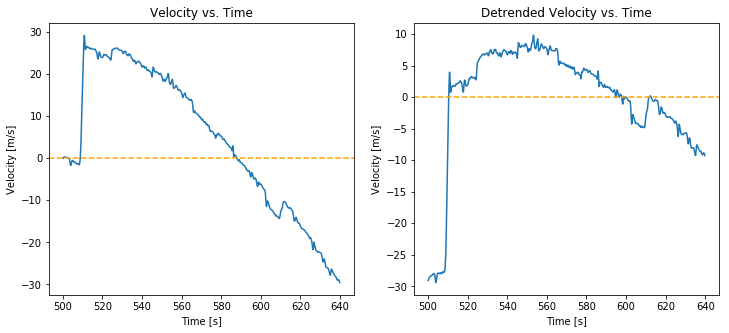

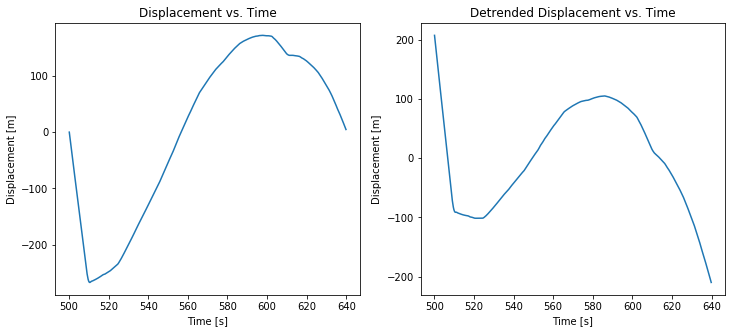

[ 2.44213007e+01  2.41713897e+01  2.39480902e+01  2.37479998e+01
  2.35507814e+01  2.33350190e+01  2.30935765e+01  2.28422136e+01
  2.26004016e+01  2.23601409e+01  2.21048245e+01  2.18418421e+01
  2.15781352e+01  2.13019413e+01  2.10098608e+01  2.06830724e+01
  2.03422975e+01  2.00006795e+01  1.96621083e+01  1.93090088e+01
  1.89419107e+01  1.85659152e+01  1.81822587e+01  1.77953100e+01
  1.74059191e+01  1.70078464e+01  1.66251497e+01  1.62471358e+01
  1.58788091e+01  1.55076189e+01  1.51333438e+01  1.47541767e+01
  1.43671038e+01  1.39700162e+01  1.35653304e+01  1.31581778e+01
  1.27537897e+01  1.23539520e+01  1.19745419e+01  1.15943255e+01
  1.12235763e+01  1.08636515e+01  1.05145679e+01  1.01802701e+01
  9.85378893e+00  9.53422222e+00  9.22492026e+00  8.92703552e+00
  8.64501966e+00  8.37680585e+00  8.11433131e+00  7.86634267e+00
  7.63856282e+00  7.44185498e+00  7.28128801e+00  7.15393349e+00
  7.06115242e+00  6.98225802e+00  6.91769644e+00  6.86789685e+00
  6.82986589e+00  6.79625

In [54]:
#First integral of acc to get velocity:
from scipy import integrate

def calculate_new_range(time_array, array_of_values, low_time, high_time):
    new_time_array = []
    new_value_array = []
    for t,v in zip(time_array, array_of_values):
        if (t > low_time and t < high_time):
            new_time_array.append(t)
            new_value_array.append(v)
    return new_time_array, new_value_array

new_time_array2, new_dacc_array2 = calculate_new_range(time_array2, dacc_array2, 500, 640)


############################# new dr ##########################
new_time_array_FB, new_dacc_array_FB = calculate_new_range(time_e_array, dacc_array_FB, 0, 200)
new_time_array_SD, new_dacc_array_SD = calculate_new_range(time_e_array, dacc_array_SD, 0, 200)


############################# new dr ##########################
int1_FB = integrate.cumtrapz(x=new_time_array_FB, y=new_dacc_array_FB, initial=0) #First integral is the velocity:
dint1_FB = signal.detrend(int1_FB)
int2_FB = integrate.cumtrapz(x=new_time_array_FB, y=dint1_FB, initial=0) #Second integral is the displacment:
dint2_FB = signal.detrend(int2_FB)


int1_SD = integrate.cumtrapz(x=new_time_array_SD, y=new_dacc_array_SD, initial=0) #First integral is the velocity:
dint1_SD = signal.detrend(int1_SD)
int2_SD = integrate.cumtrapz(x=new_time_array_SD, y=dint1_SD, initial=0) #Second integral is the displacment:
dint2_SD = signal.detrend(int2_SD)



#First integral is the velocity:
int1 = integrate.cumtrapz(x=new_time_array2, y=new_dacc_array2, initial=0)
dint1 = signal.detrend(int1)

#Second integral is the displacment:
int2 = integrate.cumtrapz(x=new_time_array2, y=dint1, initial=0)
dint2 = signal.detrend(int2)


f1 = plt.figure(figsize=(12,5))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(12,5))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(new_time_array2, int1)
ax1.set_title('Velocity vs. Time')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Velocity [m/s]')
ax1.axhline(0, color="orange", ls='--')


ax2.plot(new_time_array2, dint1)
ax2.set_title('Detrended Velocity vs. Time')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Velocity [m/s]')
ax2.axhline(0, color="orange",ls='--')

ax3.plot(new_time_array2, int2)
ax3.set_title('Displacement vs. Time')
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Displacement [m]')               

ax4.plot(new_time_array2, dint2)
ax4.set_title('Detrended Displacement vs. Time')
ax4.set_xlabel('Time [s]')
ax4.set_ylabel('Displacement [m]')


plt.show()

print(dint2_FB)
print(dint2_SD)

In [56]:
#print(motion_df)

saved_copy_motion_df = motion_df.copy(deep=True) #make a copy of the dataframe with raw data
dropped_motion_df = motion_df.dropna(subset=['Latitude', 'Longitude'])

#print(saved_copy_motion_df)


#Create arrays with just the longitude and the latitude
lat_array = np.array(dropped_motion_df.loc[:,"Latitude"], dtype=float)
lon_array = np.array(dropped_motion_df.loc[:,"Longitude"], dtype=float)

#confirm that these two arrays are the same length
print(len(lat_array))
print(len(lon_array))

#Account for how data is represented divide lat by 10^5 and lon by 10^4
lat_array[:] = [x / 10.0**5 for x in lat_array]
lon_array[:] = [x / 10.0**5 for x in lon_array]
print(lat_array[0])
print(lon_array[0])



357
357
32.85846
-117.25781


In [58]:
# Place map
gmap = gmplot.GoogleMapPlotter(lat_array[0], lon_array[0], 13)
gmap.scatter(lat_array, lon_array, '#3B0B39', size=5, marker=False)
gmap.plot(lat_array, lon_array, 'cornflowerblue', edge_width = 3.0)


# Draw
gmap.draw("dead-reckoning-IA.html")